# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
train_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_train_data_7.csv", index_col=0)
test_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_test_data_7.csv", index_col=0)

In [61]:
drop_col = 'type'
train_data7 = train_data.drop(drop_col, axis=1)
test_data7 = test_data.drop(drop_col, axis=1)

# 데이터 전처리

### 새로운 Feature 추가하기

In [28]:
# # 모터 전류 당 공기 유량은 압축기의 효율성
# train_data7['air_inflow_per_motor_current'] = train_data7['air_inflow'] / train_data7['motor_current']	
# test_data7['air_inflow_per_motor_current'] = test_data7['air_inflow'] / test_data7['motor_current']

# # 압축기와 모터의 상태를 모두 고려한 압축기 효율1
# train_data7['Compressor_Efficiency1'] = train_data7['out_pressure'] * train_data7['air_inflow'] / train_data7['motor_current'] / 3.5168
# test_data7['Compressor_Efficiency1'] = test_data7['out_pressure'] * test_data7['air_inflow'] / test_data7['motor_current'] / 3.5168

# # 압축기와 모터의 상태를 모두 고려한 압축기 효율2
# train_data7['Motor_Efficiency'] = (train_data7['motor_current'] * train_data7['motor_rpm']) / (746 * 1000)
# test_data7['Motor_Efficiency'] = (test_data7['motor_current'] * test_data7['motor_rpm']) / (746 * 1000)

# # 압축기의 효율2
# train_data7['Compressor_Efficiency2'] = (train_data7['out_pressure'] * train_data7['air_inflow'] * (train_data7['air_end_temp'] - 25)) / (train_data7['motor_current'] * train_data7['motor_vibe'] * 3.6)
# test_data7['Compressor_Efficiency2'] = (test_data7['out_pressure'] * test_data7['air_inflow'] * (test_data7['air_end_temp'] - 25)) / (test_data7['motor_current'] * test_data7['motor_vibe'] * 3.6)

# # 압축기의 배출량
# train_data7['Discharge_Volume'] = (train_data7['air_inflow'] / 60) * ((train_data7['air_end_temp'] + 273) / 273) * (train_data7['out_pressure'] / 1.01325)
# test_data7['Discharge_Volume'] = (test_data7['air_inflow'] / 60) * ((test_data7['air_end_temp'] + 273) / 273) * (test_data7['out_pressure'] / 1.01325)

# # 공기의 밀도
# train_data7['air_density'] = train_data7['out_pressure'] / (287 * (train_data7['air_end_temp'] + 273))
# test_data7['air_density'] = test_data7['out_pressure'] / (287 * (test_data7['air_end_temp'] + 273))

In [62]:
df_train = train_data7.copy()
df_test = test_data7.copy()

In [30]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558 entries, 6831 to 7388
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   air_inflow                    558 non-null    float64
 1   air_end_temp                  558 non-null    float64
 2   out_pressure                  558 non-null    float64
 3   motor_current                 558 non-null    float64
 4   motor_rpm                     558 non-null    float64
 5   motor_temp                    558 non-null    float64
 6   motor_vibe                    558 non-null    float64
 7   air_inflow_per_motor_current  558 non-null    float64
 8   Discharge_Volume              558 non-null    float64
 9   Compressor_Efficiency1        558 non-null    float64
 10  Motor_Efficiency              558 non-null    float64
 11  Compressor_Efficiency2        558 non-null    float64
 12  air_density                   558 non-null    float64
dtypes

In [25]:
# # 이전 시간대 대비 차이 계산 (delta)
# df_delta = train_data7.diff(periods=1)
# df_delta.columns = [col+"_delta" for col in train_data7.columns]

# # 이전 시간대 대비 변화율 계산 (delta rate)
# df_delta_rate = train_data7.pct_change(periods=1)
# df_delta_rate.columns = [col+"_delta_rate" for col in train_data7.columns]

# # # 이동평균 계산 (moving average)
# # window_size = 3 # 윈도우 크기
# # df_ma3 = train_data7.rolling(window_size).mean()
# # df_ma3.columns = [col+"_ma3" for col in train_data7.columns]

# # # 이동평균 계산 (moving average)
# # window_size = 5 # 윈도우 크기
# # df_ma5 = train_data7.rolling(window_size).mean()
# # df_ma5.columns = [col+"_ma5" for col in train_data7.columns]

# # # 이동평균 계산 (moving average)
# # window_size = 10 # 윈도우 크기
# # df_ma10 = train_data7.rolling(window_size).mean()
# # df_ma10.columns = [col+"_ma10" for col in train_data7.columns]

# 상관관계 계산 (correlation)
df_corr = train_data7.corr()

# 새로운 feature들을 데이터프레임에 추가하기
# df_train = pd.concat([train_data7], axis=1)

# # # 상관관계 행렬을 csv 파일로 저장하기
# # df_corr.to_csv("correlation_matrix.csv")

# # 맨 처음과 맨 마지막 데이터의 결측치 처리하기
# df_train = df_train.fillna(method="bfill").fillna(method="ffill")

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,air_inflow_per_motor_current,Discharge_Volume
air_inflow,1.000000,0.999992,NaN,0.999992,0.999992,0.999992,0.999970,0.128984,0.999774
air_end_temp,0.999992,1.000000,NaN,1.000000,1.000000,1.000000,0.999977,0.125204,0.999764
out_pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motor_current,0.999992,1.000000,NaN,1.000000,1.000000,1.000000,0.999977,0.125215,0.999765
motor_rpm,0.999992,1.000000,NaN,1.000000,1.000000,1.000000,0.999977,0.125227,0.999765
motor_temp,0.999992,1.000000,NaN,1.000000,1.000000,1.000000,0.999977,0.125235,0.999766
motor_vibe,0.999970,0.999977,NaN,0.999977,0.999977,0.999977,1.000000,0.125276,0.999750
air_inflow_per_motor_current,0.128984,0.125204,NaN,0.125215,0.125227,0.125235,0.125276,1.000000,0.128406
Discharge_Volume,0.999774,0.999764,NaN,0.999765,0.999765,0.999766,0.999750,0.128406,1.000000


In [ ]:
# 이전 시간대 대비 차이 계산 (delta)
df_delta = test_data7.diff(periods=1)
df_delta.columns = [col+"_delta" for col in test_data7.columns]

# 이전 시간대 대비 변화율 계산 (delta rate)
df_delta_rate = test_data7.pct_change(periods=1)
df_delta_rate.columns = [col+"_delta_rate" for col in test_data7.columns]

# # # 이동평균 계산 (moving average)
# # window_size = 3 # 윈도우 크기
# # df_ma3 = test_data7.rolling(window_size).mean()
# # df_ma3.columns = [col+"_ma3" for col in test_data7.columns]

# # # 이동평균 계산 (moving average)
# # window_size = 5 # 윈도우 크기
# # df_ma5 = test_data7.rolling(window_size).mean()
# # df_ma5.columns = [col+"_ma5" for col in test_data7.columns]

# # # 이동평균 계산 (moving average)
# # window_size = 10 # 윈도우 크기
# # df_ma10 = test_data7.rolling(window_size).mean()
# # df_ma10.columns = [col+"_ma10" for col in test_data7.columns]

# # 상관관계 계산 (correlation)
# df_corr = test_data7.corr()

# 새로운 feature들을 데이터프레임에 추가하기
df_test = pd.concat([test_data7, df_delta, df_delta_rate], axis=1)

# # 상관관계 행렬을 csv 파일로 저장하기
# df_corr.to_csv("correlation_matrix.csv")

# 맨 처음과 맨 마지막 데이터의 결측치 처리하기
df_test = df_test.fillna(method="bfill").fillna(method="ffill")

# 모델링

### PyTorch 모델링

In [63]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

In [64]:
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
fix_seed(42)

In [65]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [66]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim1),
#             nn.ReLU(),
#             nn.Linear(hidden_dim1, hidden_dim2),
#             nn.ReLU(),
#             nn.Linear(hidden_dim2, encoding_dim), # 추가된 히든 레이어
#             nn.ReLU() # 추가된 히든 레이어
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, hidden_dim2), # 추가된 히든 레이어
#             nn.ReLU(), # 추가된 히든 레이어
#             nn.Linear(hidden_dim2, hidden_dim1),
#             nn.ReLU(),
#             nn.Linear(hidden_dim1, input_dim),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [67]:
# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train)
test_data_scaled = scaler.transform(df_test)

# Convert numpy arrays to torch tensors
train_data_scaled = torch.from_numpy(train_data_scaled).float()
test_data_scaled = torch.from_numpy(test_data_scaled).float()

In [85]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim1 = 32
hidden_dim2 = 64

model = Autoencoder()

# Compile and train the autoencoder with early stopping
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 10
count = 0

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=7, bias=True)
  )
)


In [86]:
model_name = 'type7_timeSeries_plus2_ver3'

In [87]:
for epoch in range(10000):
    train_loss = 0
    for i in range(0, len(train_data_scaled), 32):
        inputs = train_data_scaled[i:i+32]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_scaled)/32
    with torch.no_grad():
        val_loss = criterion(model(test_data_scaled), test_data_scaled)
        if val_loss < best_loss:
            count = 0
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
        else:
            count += 1
        if count >= patience:
            print("Early stopping!")
            break
    if epoch:
        print(f"Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss.item()}")

Epoch 1, train loss: 0.8213427656440324, val loss: 0.6499438285827637
Epoch 2, train loss: 0.7623265994492398, val loss: 0.5929230451583862
Epoch 3, train loss: 0.6860049873270014, val loss: 0.5196626782417297
Epoch 4, train loss: 0.585310669355495, val loss: 0.4224730432033539
Epoch 5, train loss: 0.45716554375105006, val loss: 0.3077441453933716
Epoch 6, train loss: 0.31551836895686325, val loss: 0.19400344789028168
Epoch 7, train loss: 0.1869755021987423, val loss: 0.10563252866268158
Epoch 8, train loss: 0.09792385819137737, val loss: 0.055148646235466
Epoch 9, train loss: 0.05186599877572829, val loss: 0.034085921943187714
Epoch 10, train loss: 0.028839620851701307, val loss: 0.016091976314783096
Epoch 11, train loss: 0.012028239907756928, val loss: 0.007227190304547548
Epoch 12, train loss: 0.0069072510926954205, val loss: 0.005701832473278046
Epoch 13, train loss: 0.005279592608892789, val loss: 0.0044638789258897305
Epoch 14, train loss: 0.003834690898656845, val loss: 0.003794

In [88]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = model(test_data_scaled)
# test_data_reconstructed

In [89]:
reconstruction_error = torch.mean(torch.square(test_data_scaled - test_data_reconstructed), axis=1)
# reconstruction_error

In [90]:
# reconstruction_error[511]=4.374107473064214e-05
# reconstruction_error[517]=4.374107473064214e-05
# reconstruction_error[528]=4.374107473064214e-05
# reconstruction_error[529]=4.374107473064214e-05


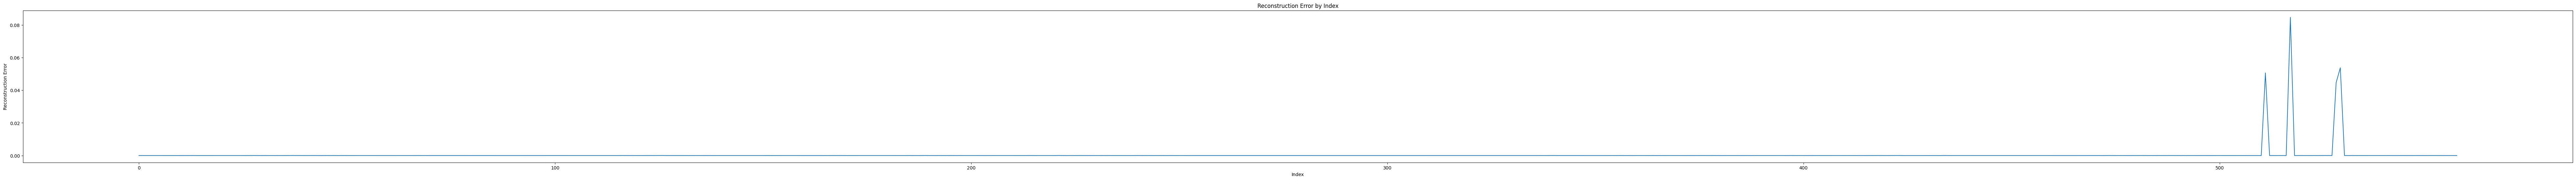

In [91]:
# 인덱스별 reconstruction_error 값을 그래프로 그립니다.
plt.figure(figsize=(100,6))
plt.plot(range(len(reconstruction_error)), reconstruction_error.detach().numpy())
# plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

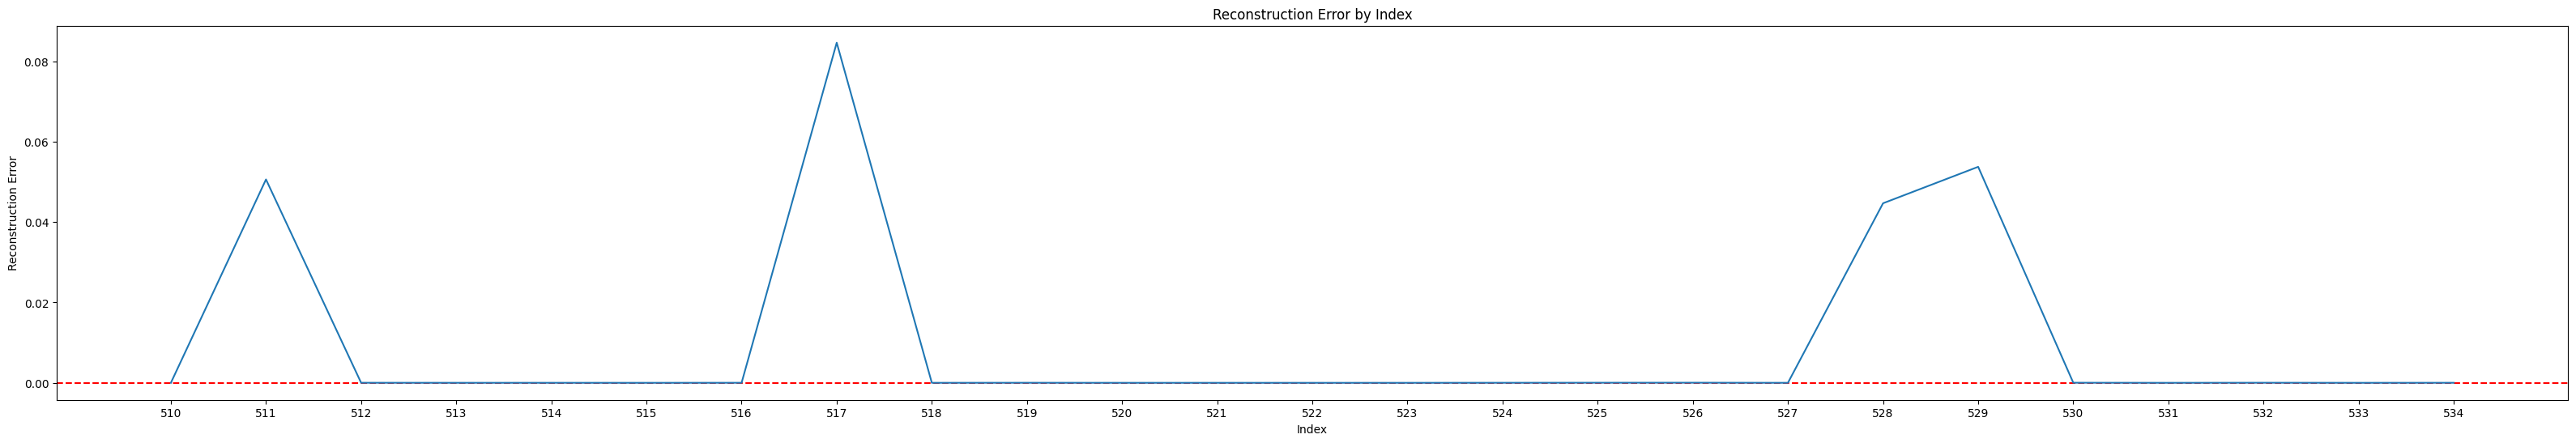

In [92]:
# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 510
end_index = 535
plt.figure(figsize=(40,6))
plt.xticks(np.arange(start_index, end_index))
plt.axhline(y=x, color='r', linestyle='--')
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

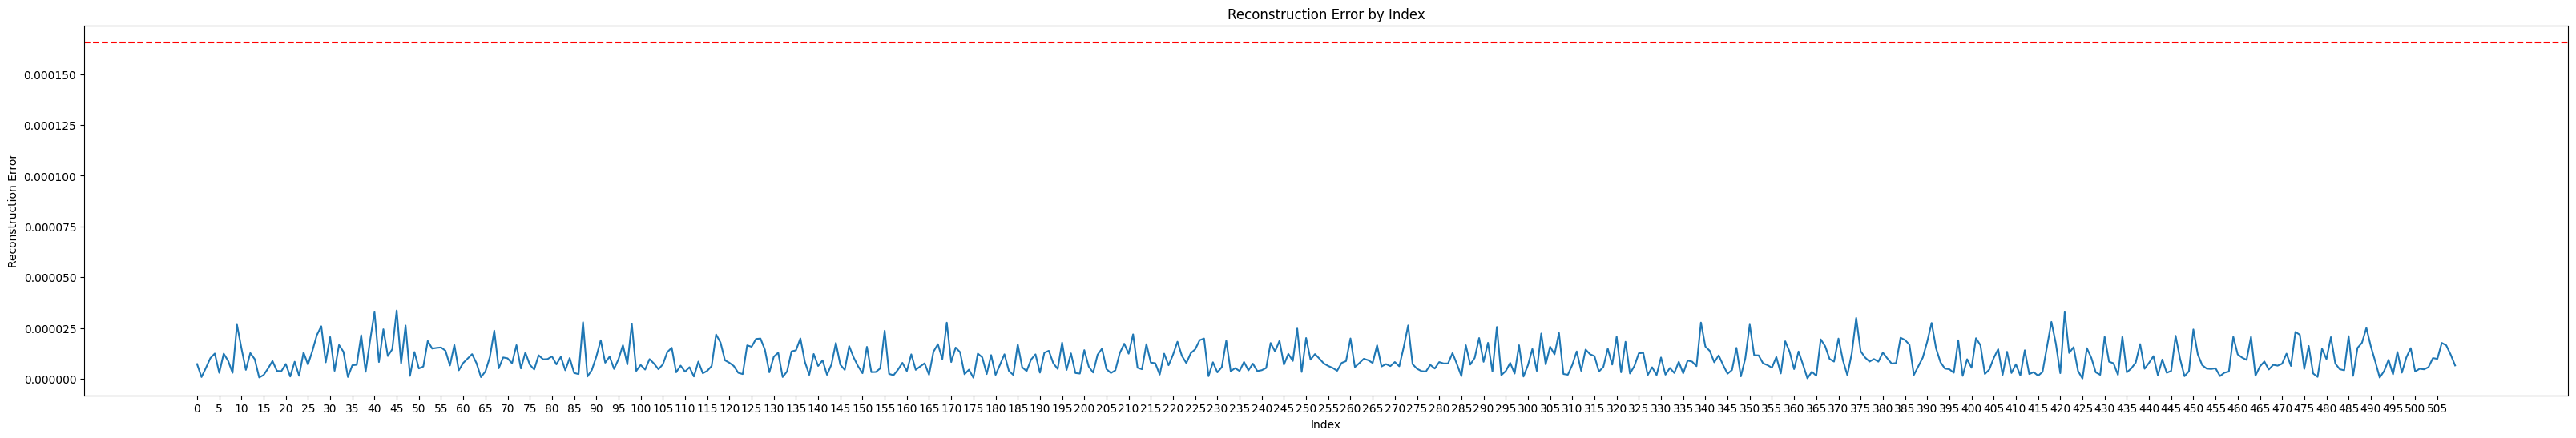

In [75]:
0# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 0
end_index = 510
plt.figure(figsize=(40,6))
plt.xticks(np.arange(start_index, end_index, 5))
plt.axhline(y=x, color='r', linestyle='--')
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

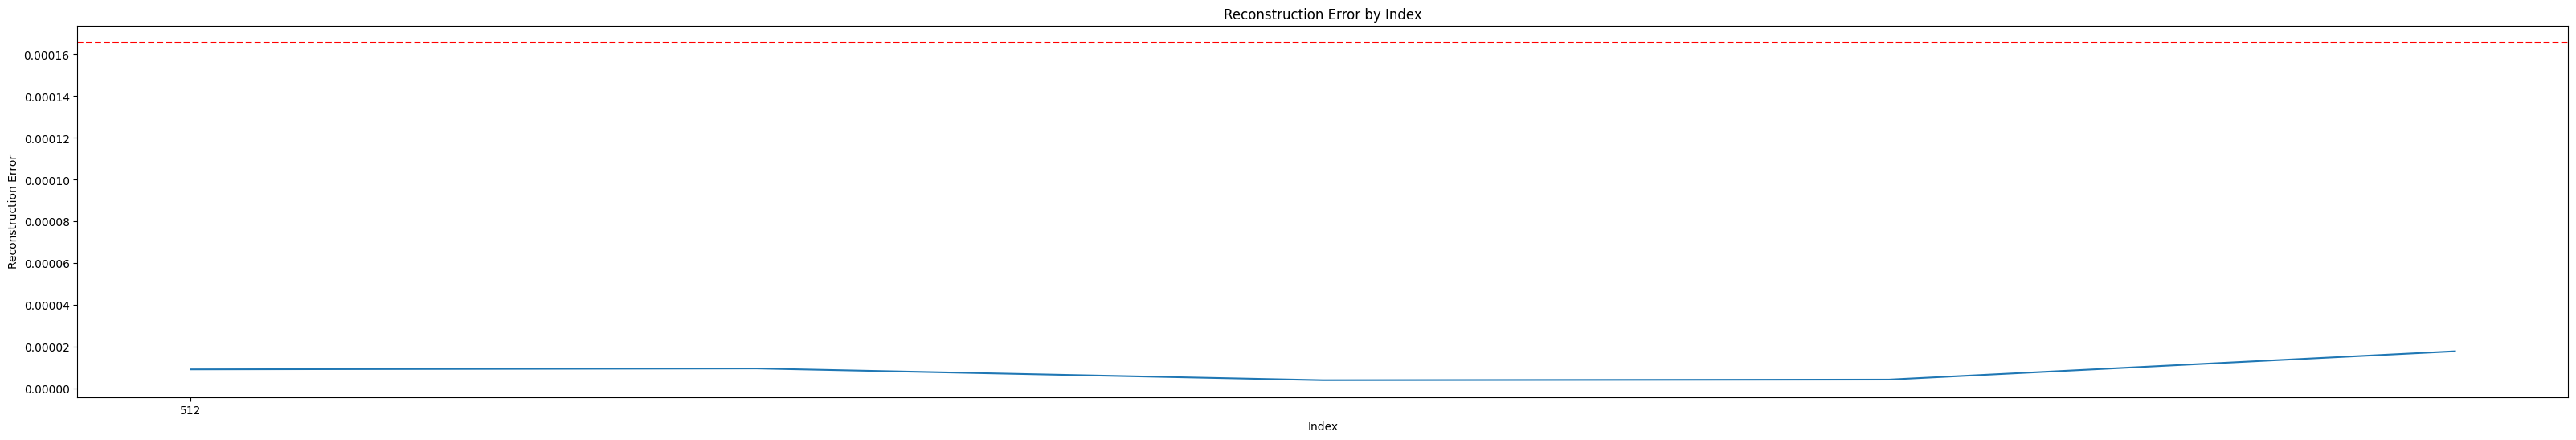

In [76]:
# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 512
end_index = 517
plt.figure(figsize=(40,6))
plt.xticks(np.arange(start_index, end_index, 5))
plt.axhline(y=x, color='r', linestyle='--')
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

In [79]:
# 527이 이상함
start_idx = 0
end_idx = 510
reconstruction_error_max = torch.max(reconstruction_error[start_idx:end_idx+1])

x = float(reconstruction_error_max)
x

3.374107473064214e-05

In [ ]:
start_idx = 510
end_idx = 530
reconstruction_error_mean = torch.mean(reconstruction_error[start_idx:end_idx+1])

z = float(reconstruction_error_mean)
z

15.47747802734375

In [ ]:
start_idx = 0
end_idx = 510
reconstruction_error_max = torch.max(reconstruction_error[start_idx:end_idx+1])

y = float(reconstruction_error_max)
y

0.032797686755657196

In [ ]:
# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error.detach().numpy(), 95.153)
threshold

0.03398557643001935

In [ ]:
# Predict anomalies in test_data
test_prediction7 = (reconstruction_error.detach().numpy() > threshold).astype(int)

# 데이터 저장

In [ ]:
from collections import Counter

count = Counter(test_prediction7)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  531
Number of 1s:  27


In [ ]:
file_name = model_name + '_th95153'

In [ ]:
# 코랩에 저장
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': test_prediction7}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

In [ ]:
# 구글드라이브에 저장(연동 필요요)
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")

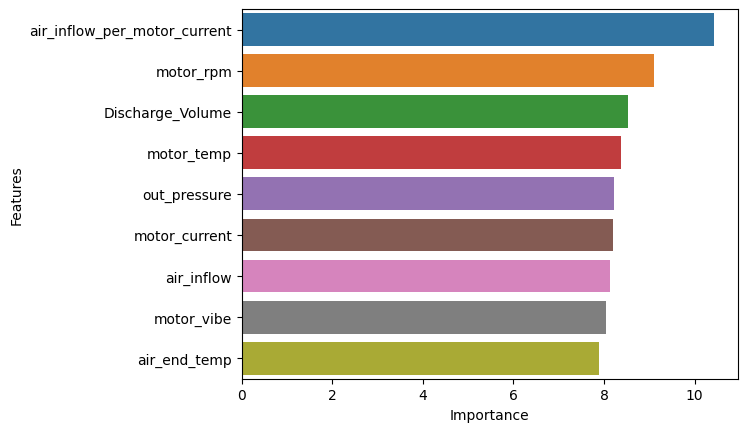

In [ ]:
# 가중치 추출
encoder_weights = model.encoder[0].weight.data.numpy()
decoder_weights = model.decoder[0].weight.data.numpy()

# 각 feature의 중요도 계산
importance = np.abs(np.vstack([encoder_weights, decoder_weights[:, :9]])).sum(axis=0)

# 중요도가 높은 feature 순서대로 출력
sorted_idx = np.argsort(importance)[::-1]
feature_names = df_test.columns  # 입력 데이터의 각 열에 대한 이름 리스트
sorted_feature_names = [feature_names[idx] for idx in sorted_idx]
sorted_importance = importance[sorted_idx]

# 중요도가 높은 feature 순서대로 그래프 그리기
# plt.figure(figsize=(10, 20))
sns.barplot(y=sorted_feature_names, x=sorted_importance)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()